In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import color_palette
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

color_pal = color_palette()

# Modeling a Problem of Regression

In [2]:
X, y = make_regression(
    n_samples = 1000,
    n_features = 30,
    n_targets = 1,
    noise = 8.0,
    random_state = 926
)

### Transform it into a Time Series Regression problem

In [3]:
X = pd.DataFrame(data = X, columns=[f"feature {i}" for i in range(1, 31)], index = pd.date_range(start="2020-01-01", periods=1000, freq="D"))
y = pd.DataFrame(data = y, columns=["Target"], index=pd.date_range(start="2020-01-01", periods=1000, freq="D"))

### Train / Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Optimize a Model of RandomForest using GridSearchCV

In [5]:
#parameters we are going to test
param_grid = {
    "n_estimators": [100, 150, 200, 300],
    "max_depth": [ 2, 4, 6, 8],
    "ccp_alpha": [0, 0.1, 0.01]
}

#our RandomForest model
model = RandomForestRegressor(
    criterion = "squared_error", #default parameter
    bootstrap = True, #default parameter
    n_jobs = -1,
    random_state = 926,
)

tscv = TimeSeriesSplit(n_splits=4)

#GridSearchCV function to test all parameters and choose the best of them.
grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = "neg_mean_absolute_percentage_error",
    n_jobs = -1,
    cv = tscv
)

grid_search.fit(X_train, y_train.to_numpy().ravel())

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=926),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.1, 0.01], 'max_depth': [2, 4, 6, 8],
                         'n_estimators': [100, 150, 200, 300]},
             scoring='neg_mean_absolute_percentage_error')

In [6]:
grid_search.best_params_

{'ccp_alpha': 0.1, 'max_depth': 8, 'n_estimators': 100}

In [7]:
#Implementing the optimized parameters in the model
model.set_params(
    n_estimators = grid_search.best_params_["n_estimators"],
    max_depth = grid_search.best_params_["max_depth"],
    ccp_alpha = grid_search.best_params_["ccp_alpha"]
)

RandomForestRegressor(ccp_alpha=0.1, max_depth=8, n_jobs=-1, random_state=926)

In [8]:
#Train the model
model.fit(X_train, y_train.to_numpy().ravel())

RandomForestRegressor(ccp_alpha=0.1, max_depth=8, n_jobs=-1, random_state=926)

In [9]:
#Make the prediction
y_pred = model.predict(X_test)

### Evaluating the model performance using MAE and r2_score

In [10]:
mae = mean_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"r2_score: {r2_score:.2f}")

MAE: 58.72
r2_score: 0.76


# Display the graph

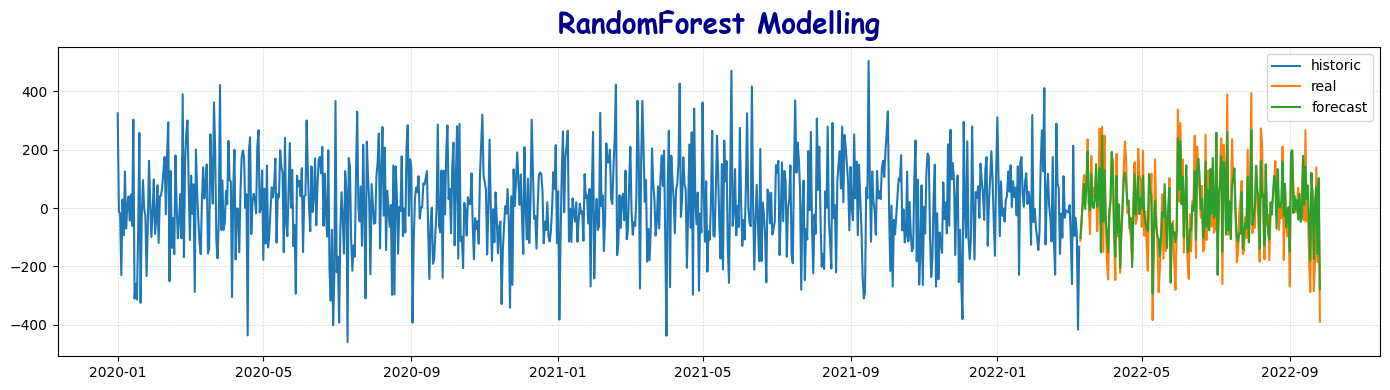

In [11]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_train.index, y_train)
ax.plot(y_test.index, y_test)
ax.plot(y_test.index, y_pred)
ax.legend(["historic", "real", "forecast"])
ax.grid(True, alpha=0.5, lw=0.5, ls='--')
plt.title("RandomForest Modelling", pad=10, fontsize=20, family="Comic Sans MS", weight="bold", color="darkblue")
plt.tight_layout()
plt.savefig("RandomForest_modelling.png")
plt.show()

# Zoom on the test part

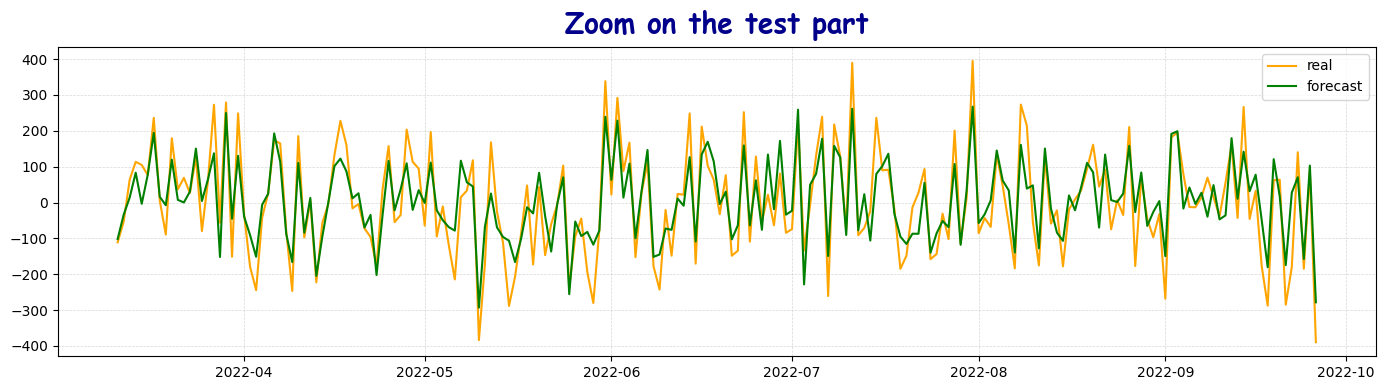

In [12]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_test.index, y_test, color="orange")
ax.plot(y_test.index, y_pred, color="green")
ax.legend(["real", "forecast"])
ax.grid(True, alpha=0.5, lw=0.5, ls='--')
plt.title("Zoom on the test part", pad=10, fontsize=20, family="Comic Sans MS", weight="bold", color="darkblue")
plt.tight_layout()
plt.savefig("RandomForest_test_part.png")
plt.show()

 

# Save the model 

In [13]:
from joblib import dump
dump(model, "RandomForestRegressor_model.joblib")

['RandomForestRegressor_model.joblib']